<a href="https://colab.research.google.com/github/yvrjsharma/Keras-edition-deux/blob/main/Keras_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep Learning for Computer Vision

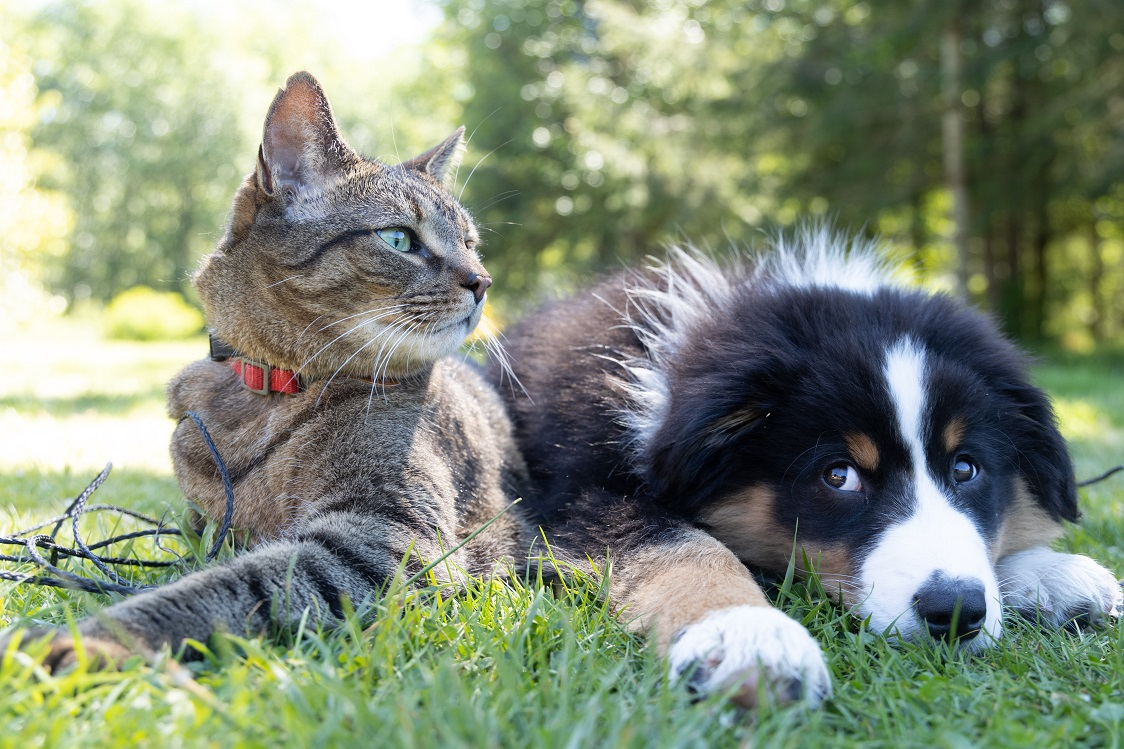

Photo by <a href="https://unsplash.com/@sita2?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Andrew S</a> on <a href="https://unsplash.com/s/photos/cats-and-dogs?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

With the rise of *Convolutional Networks* after 2012, Computer Vision has seen a rapid adoption of Deeplearning techniques in every problem domain - Image classification, segmentation, OCR, self-driving and so on. This post and chapter explains convolutional networks or *convnets* and how you can use them in image classification problems.

Lets start by implementing image classification on our previously used MNIST dataset using the Functional API we discussed in last post.
* Convnets are basically a stack of *Conv2D* and *MaxPooling2D* layers.
* As an input it should be a tensor of shape ```(image_height, image_width, image_channels)```. Channels would mean how many spectrums of light are there in the image, for example a regular colored or RGB image would have 3 channels, while a multi-spectral satelite image can have 3 RGB channels plus UV, Infrared and many more.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

#A convolutional network
inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, "softmax")(x)
model = keras.Model(inputs, outputs)

#Displaying the architecture of this conv net
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

Let's observe the above ntwork -
* Output of every conv and maxpool layer is a 3D tensor
* The height and width dimensions shrink in size as we go deeper in the network
* Last layer sia densely connected softmax classifier just like we been coding till now
* This dense layer expects a 1D input not a 3D tensor, thus we hve used a Flattening layer to flatten the 3D output to a 1D input. 

Let's train on MINST data now. You will need loss as categorical crossentropy, but since labels are all integers we woyuld use sparse categorical crossentropy. You will notice the test accyracy comes up more than 99% where as in case of densely connected netweorks it was around 97.8%. This is a good improvement of percentage points.

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
#no. of samples, height, width, channels
train_images = train_images.reshape(60000, 28,28,1).astype('float32')/255
test_images = test_images.reshape(10000, 28,28,1).astype('float32')/255

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
 
model.fit(train_images, train_labels, epochs=5,batch_size=64)

#Evaluating as well
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"test accuracy: {test_accuracy:.3f}")

Epoch 1/5
938/938 [==============================] - 14s 4ms/step - loss: 0.1532 - accuracy: 0.9521
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0414 - accuracy: 0.9869
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0288 - accuracy: 0.9910
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0225 - accuracy: 0.9934
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0279 - accuracy: 0.9905
test accuracy: 0.990


## Convolution Operation

Lets dive deeper and understand how the above network worked exactly. 

* Unlike Dense layers which learn global patterns insiode the input image, a convolutional network learns local patterns. these local patterns can be corners, straight libnes, curves, shapes and so on.

* Another way to put convnet's learning process is that it is **translational-invariant**. This means that if a convnet learns a pattern in one 3*3 pixel metric of an image, it reuses this representation to interpret the similar pattern occuring anywhere in the image after that. Dense layers have to learn a feature everytime it apprears in an image. This makes a convnet more data efficient. A convnet would thus need smaller number of images to train on to give good results.

* Also note that a convnet **learns spatial hierarchy of patterns**. This would mean that every consecutive layer, input onwards, learns more and more complex patterns from the image. For example, first few layers might learn about lines and corners, next few layers may learn about shapes, and still next few layers might start recognizing faces, cars, tyres *etc.* from an image and so on.

* In this example you saw that convnets learn in *rank-3 tensors*. These tensors are also called **feature-maps**. Two spatial axes or first two dimensions are for height and width of image while the last or third one is for *depth* or the *channels*. RGB image would have depth or channels as 3, while a greyscale image like mnist will have 1 channel only (as shown in above code).

* Every conv layer is producing an *output feature map* with height, width and an arbitrary number of channels or depth. These channels are also called **filters**. Understanding is that these filters encode specific aspects of the input data, for example, one filter might encode a face of a cat or a dog.

* Every convolution operation can be expressed using two variables:
  * Size of the pathches been extracted from the input image -- In the given example above, size of a patch is 3*3 or a 3 cross 3 pixel metric.
  * Depth of feature map - for example, 32 channels or filters that are copmputed in the first convolution operation.
* A convolution works by sliding a 3*3 size window (dimension depends on kernel suize) over the imnput image or the input feature map (for *inner* layers) and extracting at every stop a 3D patch of surrounding features (with shape as ```( window_height, window_height, input_depth)```). Each of these 3D patches is transformed into a 1D vector of shape (output_depth,) using a *convolution kernel*. All these 1D vectors are then  reassemnbled into a 3D output map of shape (height, width, output_depth) spatially. Every spatial location in this output feature map resembles the convolution over same spatial location in the input spatial feature map.

* **Padding**
  * If yuo want to include every input pixel into your convolution operation, you have add a *padding* on the sides of the image. 
  * The manner in which convolution happens by sliding a 3*3 or 5*5 window over the inout image, the resulting images gets shorter in the size. 
  * Padding argument in Conv2D layer has default value as "valid" which means no padding or we can choose to pass value as "same", wwhich would mean the layer will make sure to include padding in the input appropriately to keep the size (height, width) of output image as same.  

* **Strides**
  * Stride refers to the pixel distance travelled by the sliding window while calculating two consecutive convolutions.
  * The Conv2D layer take Stride as an agrgument and its default value is 1.
  * Stride can also decrease the size of an input image considerably for higher stride values.

* **Max-Pooling**
 * Reduces size of input feature map (height, wwidth) aggressively.
 * Max Pooling is usually done with 2*2 windows and stride 2, to downsample the feature maps by a factor of 2 (halving it every time).
 * If you remove the max pooling layers from your convnet , you might run into a few problems like -
    * The number of parameters will be very high. On a small dataset like MNIST, that can lead to overfitting. It will also lead to higher computing time and resources.
    * Secondly, this isn't conducive to learning spatial hierarchy of features. Successive conv layers will not be able to look at important features from precedding layers. The netwrok will thus not be able to learn high-level pattterns.
  * We can also use **Average Pooling**, where every 2\*2 window is replaced by the average of the pixel values instead of the max value. however, *max pooling performs better*.
  * Best performing satrategy is to use unstrided conv layers (giving gives denser map of features) followed by max pooling layers which will extract maximal features over small patches or windows.

## Approaching a problem of Computer Vision using Convnets

* Small dataset of cats and dogs - 2500 images of each. We will divide the data into train-2000, validation-1000, and testing-2000 images sets.
* **Start by setting a baseline** -- We will train a small convnet without regularization and let the model overfit.
* Next, we will introduce **Data Augmentation**, one of the main tool to reduce overfitting in CV problems.
* Later we will perform **transfer learning** using a pretrained classifier by doing -
  * Feature extraction, and
  * Fine Tuning

*Feature reuse* is one of the keay features of deep learmining models. A model trainded over large ImageNet dataset can be used to bootstratp classification solutions for problems involving *small* image datasets by *simply* using it and plugging it in with minor changes.

Lets start solving this Cat and Dog classification problem -
1. Downloading the Data 

In [1]:
#To download the data from Kaggle website - www.kaggle.com using kaggle API 

#goto to kaggle.com -> my account -> API section -> create nw API
#upload json file with your API token
from google.colab import files
files.upload()
#creating a folder and moving this json file to it
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#lets download the data
!kaggle competitions download -c dogs-vs-cats

#unzipping the trainning data
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 97% 527M/543M [00:03<00:00, 140MB/s]
100% 543M/543M [00:04<00:00, 142MB/s]
 99% 268M/271M [00:02<00:00, 110MB/s]
100% 271M/271M [00:02<00:00, 121MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 73.8MB/s]


In [2]:
#the dataset size is 25000 images, lets subsample it 
#creating smaller dataset with train, val, test as 2000,1000, 2000 images eachs respectively
#keeping equal proportion of cats and dogs images in all three sets
import os, shutil, pathlib
#dir where we uncompressed the data
original_dir = pathlib.Path("train")
#new dir to store the subset
new_base_dir = pathlib.Path("cats_vs_dogs_small")

#creating subfolders a train, val and test and moving images in them in cats and dogs directories
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

2. Building the Model
* Building a stack of alternate Conv2D layers with Relu activation and MaxPooling2D layers
* Images are bigger than mnist, thus we would need a bigger model -- more conv layers followed by maxpool8ing layers
* We will start with a 180\*180 pixel image and would reduce it to 7\*7 as the Flatten layer input. Depth of feature maps will increase progressively from input to output.
* Binary classification between a cat and a dog image category - thus we will have sigmoid as the final dense conected layer.
* We will rescale the input pixel values, which are between 0 to 255, to values between 0 and 1.  

In [5]:
#this line would mean that model will expect RGB 3 channel images or colored images as input with 180*180 pixel in size
inputs = keras.Input(shape=(180,180,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [6]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=["accuracy"])